In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import MatrixProductFunctions as mp
#import imageio
import os
import cmath
#import qutip as qt
from numba import njit
import matplotlib.animation as animation
#%matplotlib inline
import math
from ipywidgets import IntProgress, HTML
from IPython.display import display
import pickle
import sys
from multiprocessing import Process
from IPython.display import display, clear_output
import scipy.optimize as optimize

### Симуляция эволюции однофотонного состояния под воздействием гамильтониана потерь (модель гамильтониана светоделителя)

$\hat{H}_{bs} = \dfrac{\theta}{2i}(\hat{a}^{\dagger}_{sig}\hat{a}_{loss} - \hat{a}_{sig}\hat{a}^{\dagger}_{loss}) = \dfrac{\theta}{2}(\hat{q}_{sig}\hat{p}_{loss} - \hat{q}_{loss}\hat{p}_{sig}) = -i\dfrac{\theta}{2}(\hat{q}_{sig}\hat{\dfrac{d}{dq}}_{loss} - \hat{q}_{loss}\hat{\dfrac{d}{dq}}_{sig})$

#### Попробуем добавить гамильтониан гармонического осциллятора для мод

$\hat{H}_{full} = \hat{H}_{os} + \hat{H}_{bs} = (\hat{n}_{sig} + \dfrac{1}{2}) + (\hat{n}_{loss} + \dfrac{1}{2}) + \hat{H}_{bs} = \dfrac{(\hat{q}_{sig}^2 + \hat{p}_{sig}^2)}{2} + \dfrac{(\hat{q}_{loss}^2 + \hat{p}_{loss}^2)}{2} -i \dfrac{\theta}{2}(\hat{q}_{sig}\hat{\dfrac{d}{dq}}_{loss} - \hat{q}_{loss}\hat{\dfrac{d}{dq}}_{sig})$

In [186]:
for i in mp.mps_compression(mp.vec_to_mps(np.arange(2**10)), 1e-2):
    print(i.shape)

(1, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)


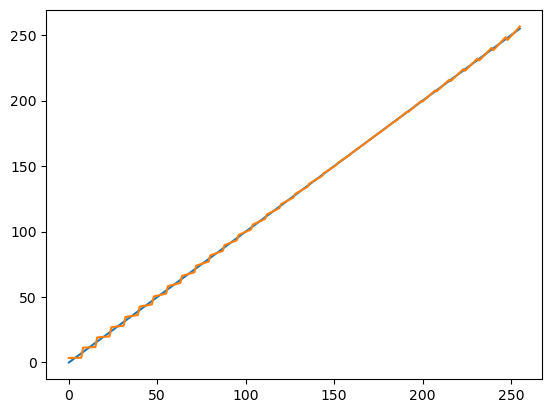

In [190]:
plt.plot(np.arange(2**8))
plt.plot(mp.tensors_multiplication(mp.mps_compression(mp.vec_to_mps(np.arange(2**8)), 1e-2)))

In [192]:
mp.tensors_multiplication(mp.mps_compression(mp.vec_to_mps(np.arange(2**8)), 1e-6))

array([-3.72479825e-14,  1.00000000e+00,  2.00000000e+00,  3.00000000e+00,
        4.00000000e+00,  5.00000000e+00,  6.00000000e+00,  7.00000000e+00,
        8.00000000e+00,  9.00000000e+00,  1.00000000e+01,  1.10000000e+01,
        1.20000000e+01,  1.30000000e+01,  1.40000000e+01,  1.50000000e+01,
        1.60000000e+01,  1.70000000e+01,  1.80000000e+01,  1.90000000e+01,
        2.00000000e+01,  2.10000000e+01,  2.20000000e+01,  2.30000000e+01,
        2.40000000e+01,  2.50000000e+01,  2.60000000e+01,  2.70000000e+01,
        2.80000000e+01,  2.90000000e+01,  3.00000000e+01,  3.10000000e+01,
        3.20000000e+01,  3.30000000e+01,  3.40000000e+01,  3.50000000e+01,
        3.60000000e+01,  3.70000000e+01,  3.80000000e+01,  3.90000000e+01,
        4.00000000e+01,  4.10000000e+01,  4.20000000e+01,  4.30000000e+01,
        4.40000000e+01,  4.50000000e+01,  4.60000000e+01,  4.70000000e+01,
        4.80000000e+01,  4.90000000e+01,  5.00000000e+01,  5.10000000e+01,
        5.20000000e+01,  

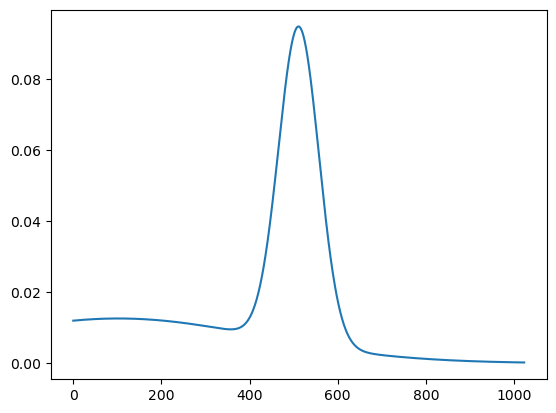

In [229]:
plt.plot(np.exp(-(np.linspace(0, 100, 1024) - 50)**2 / (2 * 20)) / np.sqrt(2 * np.pi * 20)+np.exp(-(np.linspace(0, 100, 1024) - 10)**2 / (2 * 1000)) / np.sqrt(2 * np.pi * 1000))

In [237]:
sq = mp.vec_to_mps(np.exp(-(np.linspace(0, 100, 2**10) - 50)**2 / (2 * 20)) / np.sqrt(2 * np.pi * 20)+np.exp(-(np.linspace(0, 100, 2**10) - 10)**2 / (2 * 1000)) / np.sqrt(2 * np.pi * 1000))

In [238]:
s = 0
for i in sq:
    s += sum(i.shape)
s

100

In [207]:
for i in mp.mps_compression(mp.vec_to_mps(, 1e-6)):
    print(i.shape)

(1, 2, 2)
(2, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 3)
(3, 2, 3)
(3, 2, 3)
(3, 2, 2)
(2, 2, 2)
(2, 2, 1)


In [217]:
for i in mp.sym_gauss_mps(4, 1, 15):
    print(i.shape)

(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 6)
(6, 2, 6)
(6, 2, 6)
(6, 2, 6)
(6, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(4, 2, 1)


In [2]:
t_general = 20
theta = 1
delta_t = 0.08

x_bond1 = 20
x_bond2 = 10
n1 = 10
n2 = 10
step1 = x_bond1 / 2**(n1 - 1)
step2 = x_bond2 / 2**(n2 - 1)
x_bias = 20
steps_number = t_general / delta_t
eps = 1e-6

In [3]:
# with open('Long_evolution.txt', 'w') as file:
#     file.write(f"t_general={t_general}\n")
#     file.write(f"theta={theta}\n")
#     file.write(f"delta_t={delta_t}\n")
#     file.write(f"x_bond1={x_bond1}\n")
#     file.write(f"x_bond2={x_bond2}\n")
#     file.write(f"n1={n1}\n")
#     file.write(f"n2={n2}\n")
#     file.write(f"step1={step1}\n")
#     file.write(f"step2={step2}\n")
#     file.write(f"x_bias={x_bias}\n")
#     file.write(f"steps_number={steps_number}\n")
#     file.write(f"eps={eps}\n")

In [4]:
def bound_part(n, c1, c2):
    mpo = mp.mpo_sum([np.array([[0,1],[0,0]]).reshape(1,2,2,1)]*(n-1) + [np.array([[0,-c1],[0,0]]).reshape(1,2,2,1)], [np.array([[0,0],[1,0]]).reshape(1,2,2,1)]*(n-1) + [np.array([[0,0],[c2,0]]).reshape(1,2,2,1)]) 
    return mpo

In [5]:
hamlt_1 = mp.x_mpo(n1, x_bias-x_bond1, step1) + mp.der_mpo(n2, step2)
hamlt_2 = mp.der_mpo(n1, step1) + mp.x_mpo(n2, -x_bond2, step2)
#hamlt_3 = mp.mpo_mul_num(mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n1, -x_bond1, step1), mp.x_mpo(n1, -x_bond1, step1)), mp.mpo_mul_num(mp.der2_mpo(n1, step1), -1)), 1/2) + mp.one_mpo(n2) 
#hamlt_4 = mp.one_mpo(n1) + mp.mpo_mul_num(mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n2, -x_bond2, step2), mp.x_mpo(n2, -x_bond2, step2)), mp.mpo_mul_num(mp.der2_mpo(n2, step2), -1)), 1/2)
hamiltonian = mp.mpo_mul_num(mp.mpo_sum(hamlt_1, mp.mpo_mul_num(hamlt_2, -1)), -1j*theta/2)

In [6]:
mp.mpo_to_matrix(mp.mpo_sum(mp.der_mpo(n2, step2), bound_part(n2, 1/(2*step2), 1/(2*step2)))), mp.mpo_to_matrix(mp.mpo_sum(mp.der_mpo(n1, step1), bound_part(n1, 1/(2*step1), 1/(2*step1))))

(array([[  0. ,  25.6,   0. , ...,   0. ,   0. , -25.6],
        [-25.6,   0. ,  25.6, ...,   0. ,   0. ,   0. ],
        [  0. , -25.6,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,  25.6,   0. ],
        [  0. ,   0. ,   0. , ..., -25.6,   0. ,  25.6],
        [ 25.6,   0. ,   0. , ...,   0. , -25.6,   0. ]]),
 array([[  0. ,  12.8,   0. , ...,   0. ,   0. , -12.8],
        [-12.8,   0. ,  12.8, ...,   0. ,   0. ,   0. ],
        [  0. , -12.8,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,  12.8,   0. ],
        [  0. ,   0. ,   0. , ..., -12.8,   0. ,  12.8],
        [ 12.8,   0. ,   0. , ...,   0. , -12.8,   0. ]]))

In [7]:
mp.mpo_to_matrix(mp.x_mpo(n1, -x_bond1, step1)), mp.mpo_to_matrix(mp.x_mpo(n2, -x_bond2, step2))

(array([[-20.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       , -19.9609375,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       , -19.921875 , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  19.8828125,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
          19.921875 ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,  19.9609375]]),
 array([[-10.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -9.98046875,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,  -9.9609375 , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,

#### Линеаризованное уравнение эволюции

$(1 + i\Delta t \hat{H})\psi_{t+\Delta t} = \psi_t$

In [8]:
ev_matrix = mp.mpo_sum(mp.one_mpo(n1 + n2), mp.mpo_mul_num(hamiltonian, 1j*delta_t))

In [9]:
#classic_ev_matrix = mp.mpo_to_matrix(ev_matrix)
#np.linalg.cond(classic_ev_matrix)

In [10]:
#np.dot(np.conjugate(classic_ev_matrix.T), classic_ev_matrix) - np.eye(2**(n1+n2)), np.linalg.norm(np.dot(np.conjugate(classic_ev_matrix.T), classic_ev_matrix) - np.eye(2**(n1+n2)))

#### Задаем однофотонное состояние через полиномы Эрмита

#### Рекурентное соотношение для полиномов Эрмита

$H_n(x) - 2xH_{n-1}(x) + 2(n-1)H_{n-2}(x) = 0$

$H_n(x) = 2xH_{n-1}(x) - 2(n-1)H_{n-2}(x)$

$H_0(x) = 1, H_1(x) = 2x$

In [11]:
def hermit_pol(n, x):
    h0 = 1
    h1 = 2*x
    h = h0 * (1-n) + h1 * n
    if n > 1:
        return 2*x * hermit_pol(n-1, x) - 2*(n-1) * hermit_pol(n-2, x)
    else:
        return h

#### Волновая функция фоковского состояния через полиномы Эрмита

In [12]:
def psi_fock(n, x):
    return hermit_pol(n, x) * np.exp(- x**2 / 2) / np.sqrt(2**n * math.factorial(n) *np.sqrt(np.pi))

#### График волновой функции однофотонного состояния

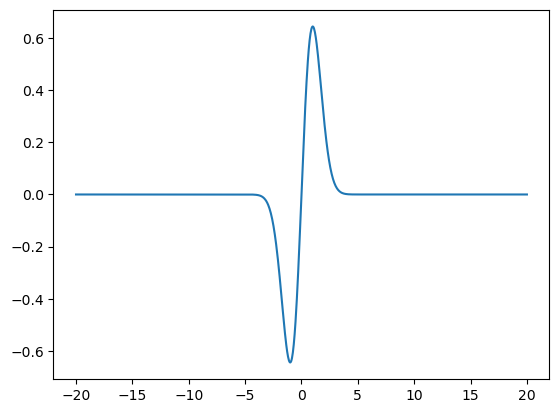

In [13]:
plt.plot(np.linspace(-x_bond1, x_bond1, 2**n1), psi_fock(1, np.linspace(-x_bond1, x_bond1, 2**n1)))

#### Мода сигнала (однофотонное состояние)

In [14]:
psi_fock_1ph = psi_fock(1, np.linspace(-x_bond1, x_bond1, 2**n1))
mps_fock_1ph = mp.vec_to_mps(psi_fock_1ph)
#mps_fock_1ph = mp.sym_gauss_mps(x_bond1, 1, n1)
signal_0, signal_N = psi_fock_1ph[0], psi_fock_1ph[-1] 

#### Мода потерь (вакуумное состояние)

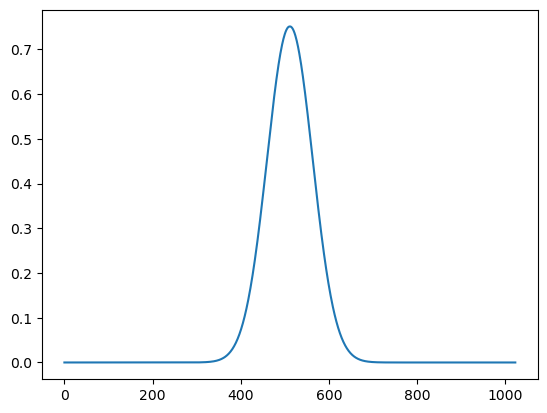

In [15]:
mps_vacuum_state = mp.vacuum_state(x_bond2, n2)
loss_0, loss_N = mp.tensors_multiplication(mps_vacuum_state)[0], mp.tensors_multiplication(mps_vacuum_state)[-1]
plt.plot(mp.tensors_multiplication(mps_vacuum_state))

In [16]:
common_mps = mps_fock_1ph + mps_vacuum_state

#### Тестирование добавочного слогаемого

In [17]:
psi_add_1 = np.zeros(2**n2)
psi_add_1[0] = loss_0/(2*step2)
psi_add_1[-1] = -loss_N/(2*step2)
mps_add_1 = mps_fock_1ph + mp.vec_to_mps(psi_add_1)

psi_add_2 = np.zeros(2**n1)
psi_add_2[0] = -signal_0/(2*step1)
psi_add_2[-1] = signal_N/(2*step1)
mps_add_2 = mp.vec_to_mps(psi_add_2) + mps_vacuum_state

operator_1 = mp.x_mpo(n1) + mp.one_mpo(n2)
operator_2 = mp.one_mpo(n1) + mp.x_mpo(n2)

In [18]:
add_part = mp.mps_mul_num(mp.mps_sum(mp.mult_mpo_by_mps(operator_1, mps_add_1), mp.mult_mpo_by_mps(operator_2, mps_add_2)), 1j*delta_t*theta/2)   

#### Решение через классическое решение СЛУ

In [137]:
classic_state = mp.tensors_multiplication(common_mps)

In [138]:
list_for_matrices2 = []
list_for_matrices2.append(classic_state)
solution2 = np.linalg.solve(classic_ev_matrix, classic_state)
list_for_matrices2.append(solution2)

NameError: name 'classic_ev_matrix' is not defined

In [139]:
h = 7
np.linalg.norm(classic_ev_matrix @ list_for_matrices2[h+1] - list_for_matrices2[h])/np.linalg.norm(list_for_matrices2[h])

NameError: name 'classic_ev_matrix' is not defined

In [49]:
j = 2
np.linalg.norm(classic_ev_matrix @ list_for_matrices2[j] - classic_state)/np.linalg.norm(classic_state)

NameError: name 'classic_ev_matrix' is not defined

100%|███████████████████████████████████████████████████████████████████████████| 70001/70001 [01:47<00:00, 653.74it/s]


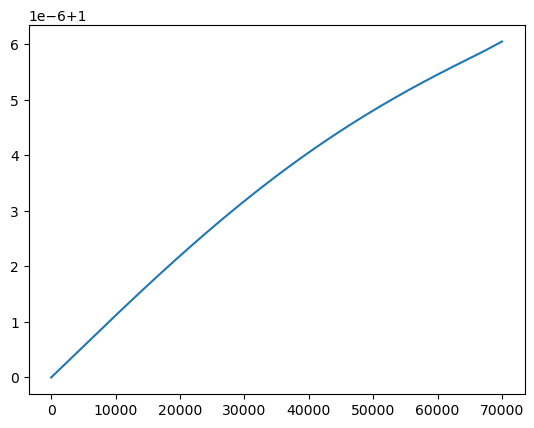

In [332]:
delta_norm = []
for i in tqdm(range(len(list_for_matrices)-1)):
    delta_norm.append(np.linalg.norm(mp.tensors_multiplication(list_for_matrices[i+1]))/np.linalg.norm(mp.tensors_multiplication(list_for_matrices[i])))
plt.plot(delta_norm)

In [183]:
i = 10
np.linalg.norm(list_for_matrices2[i+1])/np.linalg.norm(list_for_matrices2[i])

np.float64(1.0000124832345558)

In [159]:
for j in tqdm(range(10)):
    solution2 = np.linalg.solve(classic_ev_matrix, solution2)
    list_for_matrices2.append(solution2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]


In [18]:
# m = []
# for i in tqdm(range(3000)):
#     m.append(np.sqrt(np.conj(list_for_matrices2[i+1]) @ list_for_matrices2[i+1])/np.sqrt(np.conj(list_for_matrices2[i]) @ list_for_matrices2[i]))
# plt.plot(m)

In [19]:
#plt.plot(list_for_matrices2[3000])

In [20]:
#plt.plot(mp.tensors_multiplication(list_for_matrices[3000]))
#plt.plot(list_for_matrices2[3000])

In [6]:
def evolute(state, operator, steps_number, solver, initial_guess = "best", eps = 1e-6):
    if initial_guess == "best":
        guess = state
    elif type(initial_guess) == list and initial_guess[0] == "approx":
        guess = mp.mps_compression(state, initial_guess[1])
    elif type(initial_guess) == list and len(initial_guess) == len(state):
        guess = initial_guess
    else:
        raise ValueError("Некорректное условие для начального приближения состояния")
        
    list_for_matrices = []
    list_for_matrices.append(state)
    solution = solver(operator, state, guess, eps = eps)
    list_for_matrices.append(solution)
    for j in tqdm(range(steps_number-1)):
        
        if initial_guess == "best":
            guess = solution
        elif type(initial_guess) == list and initial_guess[0] == "approx":
            guess = mp.mps_compression(solution, initial_guess[1])
        elif type(initial_guess) == list and len(initial_guess) == len(state):
            guess = initial_guess
        
        solution = solver(operator, solution, guess, eps = eps)
        list_for_matrices.append(solution)
        
    return list_for_matrices

#### Эволюция однофотонного состояния под дейсвием потерь

In [19]:
list_for_matrices = []
list_for_matrices.append(common_mps)
solution = mp.mp_solve(ev_matrix, common_mps, common_mps, eps = eps)
list_for_matrices.append(solution)

In [21]:
# for j in tqdm(range(12)):
#     solution = mp.mp_solve(ev_matrix, solution, solution, eps = eps)
#     list_for_matrices.append(solution)

In [36]:
def evolute(state, operator, steps_number, solver, initial_guess = "best", eps = 1e-6):
    fig, ax = plt.subplots()
    line1, = ax.plot(np.arange(1,steps_number+1), np.zeros(steps_number))
    line2, = ax.plot(np.arange(1,steps_number+1), np.zeros(steps_number))
    #text = ax.text(0.5, 0.9, '', transform=ax.transAxes, ha='center')

    times_container = []
    start_time = time.time()
    if initial_guess == "best":
        guess = state
    elif isinstance(initial_guess, list):
        if initial_guess[0] == "approx":
            guess = mps_compression(state, initial_guess[1])
        elif len(initial_guess) == len(state):
            guess = initial_guess  
        else:
            raise ValueError("Invalid initial_guess list format")
    else:
        raise ValueError("Invalid initial_guess type")

    list_for_matrices = []
    list_for_matrices.append(state)
    solution = solver(operator, state, guess, eps = eps)
    list_for_matrices.append(solution)
    
    times_container.append(time.time()-start_time)
    
    for i in range(steps_number-1):
        if initial_guess == "best":
            guess = solution
        elif isinstance(initial_guess, list):
            if initial_guess[0] == "approx":
                guess = mps_compression(solution, initial_guess[1])
            elif len(initial_guess) == len(state):
                guess = initial_guess 
            else:
                raise ValueError("Invalid initial_guess list format")
        else:
            raise ValueError("Invalid initial_guess type")

        solution = solver(operator, solution, guess, eps = eps)
        list_for_matrices.append(solution)
        
        times_container.append(time.time()-start_time)
        
        poly_coeffs = np.polyfit(np.arange(1,i+3), times_container, 2)
        poly_func = np.poly1d(poly_coeffs)
        
        line1.set_ydata(times_container + [0]*(steps_number-len(times_container)))
        print(times_container + [0]*(steps_number-len(times_container)))
        line2.set_ydata(poly_func(np.arange(1,steps_number+1)))
        
        display(fig)
        clear_output(wait=True)
        
        plt.pause(0.1)
    return list_for_matrices

[0.06478238105773926, 0.19585704803466797, 0.8903405666351318, 1.8839256763458252, 3.403118848800659, 5.849097728729248, 9.358104705810547, 13.259280443191528, 18.198079586029053, 23.270817756652832]


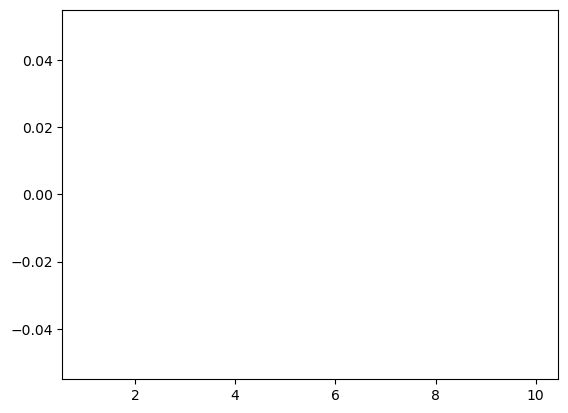

In [37]:
solutions = evolute(common_mps, ev_matrix, 10, mp.mp_solve)

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

def evolute(state, operator, steps_number, solver, initial_guess="best", eps=1e-6, chart = True):
    if chart == True:
        fig, ax = plt.subplots()
        line1, = ax.plot(np.arange(1, steps_number + 1), np.zeros(steps_number), 'r.', label='Times')
        line2, = ax.plot(np.arange(1, steps_number + 1), np.zeros(steps_number), label='Poly Fit')
        text = ax.text(0.5, 0.9, '', transform=ax.transAxes, ha='center')
        ax.legend()

    times_container = []
    start_time = time.time()
    if initial_guess == "best":
        guess = state
    elif isinstance(initial_guess, list):
        if initial_guess[0] == "approx":
            guess = mps_compression(state, initial_guess[1])
        elif len(initial_guess) == len(state):
            guess = initial_guess
        else:
            raise ValueError("Invalid initial_guess list format")
    else:
        raise ValueError("Invalid initial_guess type")

    list_for_matrices = []
    list_for_matrices.append(state)
    solution = solver(operator, state, guess, eps=eps)
    list_for_matrices.append(solution)

    times_container.append(time.time() - start_time)

    for i in range(2, steps_number + 1):
        if initial_guess == "best":
            guess = solution
        elif isinstance(initial_guess, list):
            if initial_guess[0] == "approx":
                guess = mps_compression(solution, initial_guess[1])
            elif len(initial_guess) == len(state):
                guess = initial_guess
            else:
                raise ValueError("Invalid initial_guess list format")
        else:
            raise ValueError("Invalid initial_guess type")

        solution = solver(operator, solution, guess, eps=eps)
        list_for_matrices.append(solution)

        times_container.append(time.time() - start_time)
        cut_time = 7
        if i < cut_time+1:
            poly_coeffs = np.polyfit(np.arange(1, i + 1), times_container, 2)
        else:
            poly_coeffs = np.polyfit(np.arange(i-(cut_time-1), i+1), times_container[i-cut_time:i], 2)
        poly_func = np.poly1d(poly_coeffs)
        
        if chart == True:
            line1.set_ydata(times_container + [0]*(steps_number-len(times_container)))
            line2.set_ydata(poly_func(np.arange(1, steps_number + 1)))
            ax.relim()
            ax.autoscale_view()
            text.set_text(f'Общее время выполнения {np.round(poly_func(steps_number))} секунды, \n Оставшееся время {np.round(poly_func(steps_number)-times_container[i-1])} секунды')
            clear_output(wait=True)
            display(fig)
            plt.pause(0.001)  # Пауза для обновления графика
            plt.show()
    return list_for_matrices, times_container

# Пример использования функции
# result = evolute(state, operator, steps_number, solver)


In [142]:
def fitting_curve(x, a, b, c, d):
    return a + b*x + c*np.exp(d*x)

In [134]:
def calculate_photon_number_in_set_of_solutions(set_of_solutions, n1, n2, x_bond1, x_bond2, step1, step2, x_bias, solver, bound = False, step = 1, chart = True):
    if chart == True:
        real_length = len(range(1, len(set_of_solutions)+1, step))
        fig, ax = plt.subplots()
        line1, = ax.plot(np.arange(1, real_length + 1), np.zeros(real_length), 'r.', label='Times')
        line2, = ax.plot(np.arange(1, real_length + 1), np.zeros(real_length), label='Poly Fit')
        text = ax.text(0.5, 0.9, '', transform=ax.transAxes, ha='center')
        ax.legend()

    times_container = []
    start_time = time.time()
    j = 0

    photon_number_in_mode1 = []
    photon_number_in_mode2 = []
    photon_number_common = []
    for i in tqdm(range(1, len(set_of_solutions)+1, step)):
        j += 1
        photon_number_in_mode1.append(np.round(solver(set_of_solutions[j-1], 0, n1, x_bias-x_bond1, step1), 3))
        photon_number_in_mode2.append(np.round(solver(set_of_solutions[j-1], 1, n2, -x_bond2, step2), 3))
        photon_number_common = list(map(add, photon_number_in_mode1, photon_number_in_mode2))

        times_container.append(time.time() - start_time)
        if chart == True:
            cut_time = 7
            if j < cut_time+1:
                params, pcov = optimize.curve_fit(fitting_curve, np.arange(1, j + 1), times_container)
                #poly_coeffs = np.polyfit(np.arange(1, j + 1), times_container, 2)
            else:
                params, pcov = optimize.curve_fit(fitting_curve, np.arange(j-(cut_time-1), j+1), times_container[j-cut_time:j])
                #poly_coeffs = np.polyfit(np.arange(j-(cut_time-1), j+1), times_container[j-cut_time:j], 2)
            
            #poly_func = np.poly1d(poly_coeffs)  
            line1.set_ydata(times_container + [0]*(real_length-len(times_container)))
            #line2.set_ydata(poly_func(np.arange(1, real_length + 1)))
            line2.set_ydata(fitting_curve(np.arange(1, real_length + 1), *params))
            ax.relim()
            ax.autoscale_view()
            text.set_text(f'Общее время выполнения {np.round(poly_func(real_length))} секунды, \n Оставшееся время {np.round(poly_func(real_length)-times_container[j-1])} секунды')
            clear_output(wait=True)
            display(fig)
            plt.pause(0.001)  # Пауза для обновления графика
            plt.show()

    return photon_number_in_mode1, photon_number_in_mode2, photon_number_common

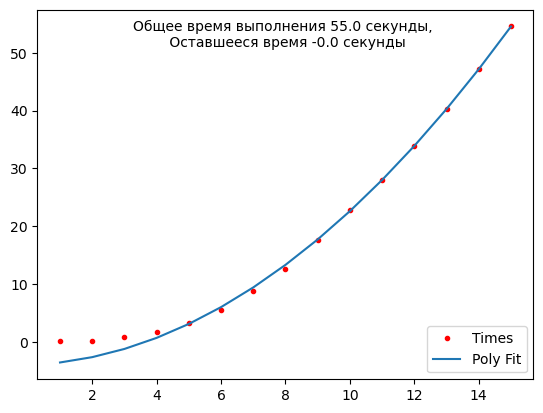

54.667606592178345


In [137]:
s = time.time()
solutions = evolute(common_mps, ev_matrix, 15, mp.mp_solve, chart = True)
print(time.time()-s)

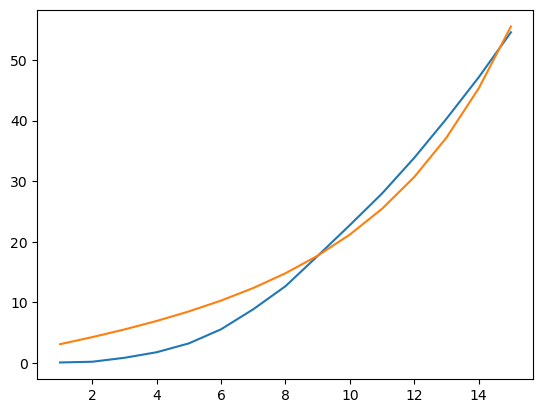

In [155]:
plt.plot(np.arange(1, 15 + 1), solutions[1])
plt.plot(np.arange(1, 15 + 1), np.exp(0.25*np.arange(1, 15 + 1))+np.ones(15)*1+0.8*np.arange(1, 15 + 1))

In [156]:
params, pcov = optimize.curve_fit(fitting_curve, np.arange(1, 6), solutions[1][:5])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [102]:
from operator import add

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]


TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=1

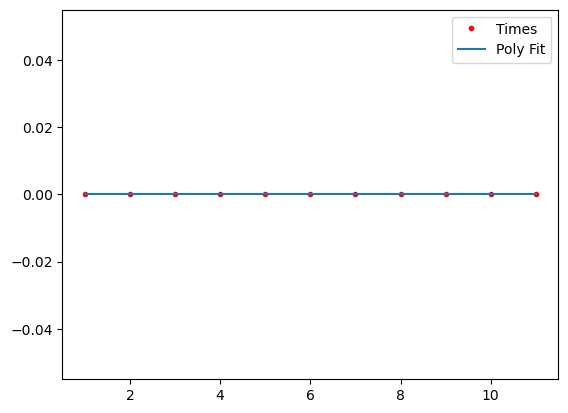

In [131]:
s = time.time()
photon_statistics = calculate_photon_number_in_set_of_solutions(solutions, n1, n2, x_bond1, x_bond2, step1, step2, x_bias, mp.calculate_photon_number3, bound = False, step = 2, chart = True)
print(time.time()-s)

In [48]:
len(list_for_matrices)

1002

In [78]:
fast_m = []
for i in tqdm(range(10)):
    a = time.time()
    mp.calculate_photon_number2(list_for_matrices[i], 0, n1, -x_bond1, step1)
    fast_m.append(time.time() - a)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.73it/s]


In [79]:
mp.calculate_photon_number2(list_for_matrices[i], 0, n1, -x_bond1, step1)

array([[4.99495189+0.j]])

In [54]:
slow_m = []
for i in tqdm(range(10)):
    a = time.time()
    reddm1 = mp.find_reduced_density_matrix(list_for_matrices[i], 0, n1)
    reddm1 = reddm1 / np.trace(reddm1)
    mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = 'periodic')
    slow_m.append(time.time() - a)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it]


In [80]:
reddm1 = mp.find_reduced_density_matrix(list_for_matrices[i], 0, n1)
reddm1 = reddm1 / np.trace(reddm1)
mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = 'periodic')

np.float64(4.999626817489371)

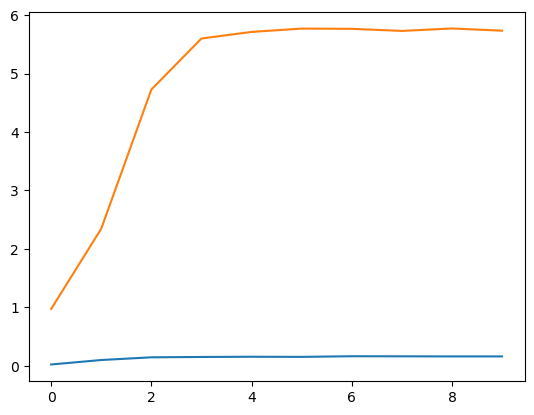

In [55]:
plt.plot(fast_m)
plt.plot(slow_m)

In [20]:
# i = 3000
# np.real(mp.identity(np.conj(mp.tensors_multiplication(list_for_matrices[i])), list_for_matrices2[i]))

In [122]:
l = []
for i in tqdm(range(0, 40000, 100)):
    l.append(np.sqrt(np.real(mp.mps_scalar_multiplication(list_for_matrices[i+1], list_for_matrices[i+1])))/np.sqrt(np.real(mp.mps_scalar_multiplication(list_for_matrices[0], list_for_matrices[0]))))

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 721.09it/s]


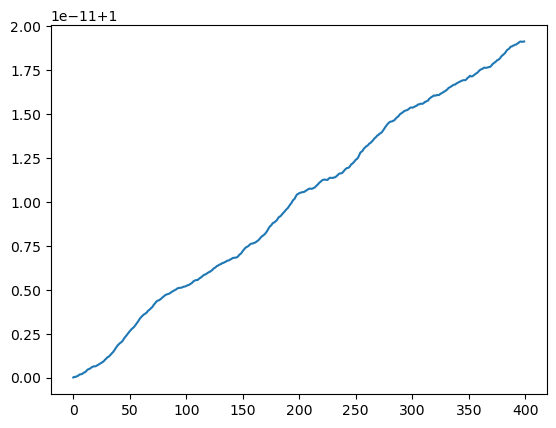

In [123]:
#plt.plot(l_100)
#plt.plot(l_200)
#plt.plot(l_300)
plt.plot(l)

In [ ]:
#plt.plot(mp.tensors_multiplication(list_for_matrices[0]))
#plt.plot(mp.tensors_multiplication(list_for_matrices[]))

In [178]:
np.sqrt(np.real(mp.mps_scalar_multiplication(list_for_matrices[0], list_for_matrices[0]))), np.sqrt(np.real(mp.mps_scalar_multiplication(list_for_matrices[1], list_for_matrices[1])))

(np.float64(9.841429285251719), np.float64(9.841431362779485))

In [179]:

# list_for_matrices2 = []
# list_for_matrices2.append(common_mps)
# plt.figure(figsize = (10, 6))
# solution = mp.mp_solve(ev_matrix, common_mps, mp.x_mps(n1 + n2), eps = 1e-6)
# list_for_matrices2.append(solution)
# for j in tqdm(range(200)):
#     solution = mp.mp_solve(ev_matrix, solution, mp.x_mps(n1 + n2), eps = 1e-6)
#     list_for_matrices2.append(solution)


In [413]:
len(list_for_matrices)

40002

In [125]:
shorten_list_for_matrices = []
for i in range(0, len(list_for_matrices), 100):
    shorten_list_for_matrices.append(list_for_matrices[i])

In [5]:
len(shorten_list_for_matrices)

401

#### Сохранение значений в файл

In [179]:
# short_list = []
# for i in range(0, len(list_for_matrices), 100):
#     short_list.append(list_for_matrices[i])

In [282]:
#len(short_list)

In [513]:
# with open('Correct_evolution_full.pkl', 'wb') as f:
#     pickle.dump(shorten_list_for_matrices, f)

In [4]:
with open('Correct_evolution_short.pkl', 'rb') as f:
    shorten_list_for_matrices = pickle.load(f)

#### Построение функции Вигнера для однофотонного состояния в конце эволюции

#### Построение матрицы плотности (действительной её части)

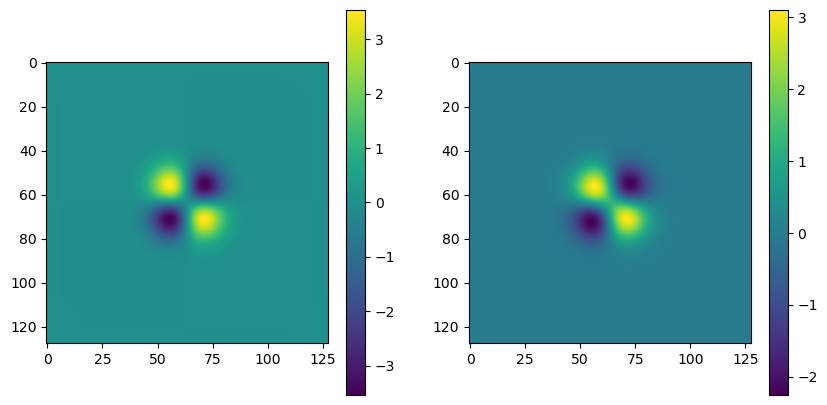

In [276]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dmatrix0 = mp.find_reduced_density_matrix(list_for_matrices[0], 0, n1)
dmatrix1 = mp.find_reduced_density_matrix(list_for_matrices[7000], 0, n1)
im1 = axes[0].imshow(np.real(dmatrix0))
im2 = axes[1].imshow(np.real(dmatrix1))
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

#### Построение матрицы плотности как 3D-поверхности

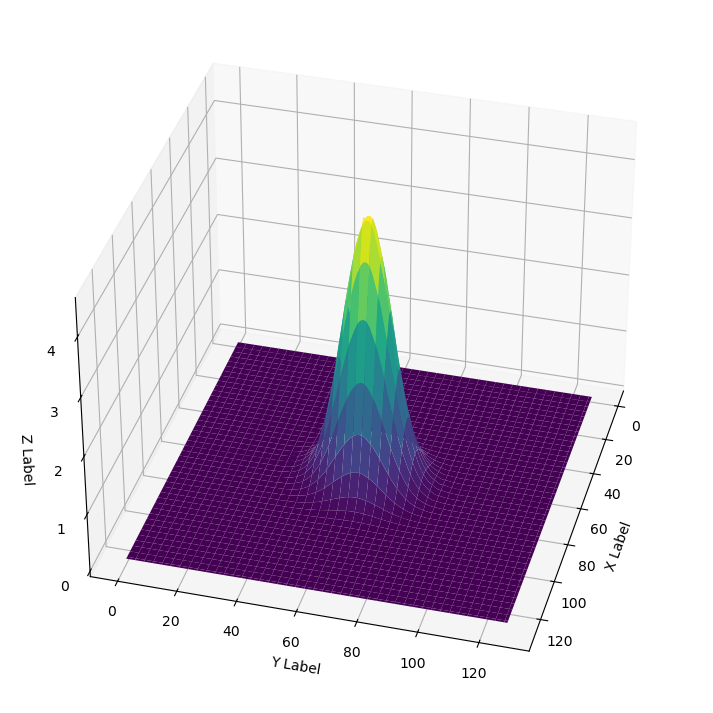

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Пример матрицы значений
Z = np.real(reddm2)

# Создаем сетку координат X и Y
X = np.arange(Z.shape[0])
Y = np.arange(Z.shape[1])
X, Y = np.meshgrid(X, Y)

# Создаем 3D-график
fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111, projection='3d')

# Построение поверхности
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.view_init(elev=35, azim=15)

# Добавляем метки осей
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Отображаем график
plt.show()


Количество фотонов в сигнале:  0.979 Количество фотонов в потерях:  0.028
Общее количество фотонов:  1.007


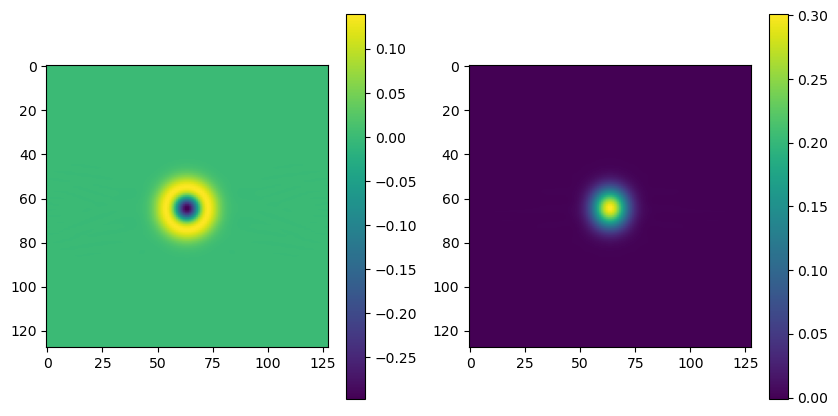

In [129]:
j = 40000
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
reddm1 = mp.find_reduced_density_matrix(list_for_matrices[j], 0, n1)
reddm2 = mp.find_reduced_density_matrix(list_for_matrices[j], 1, n2)
reddm3 = mp.find_reduced_density_matrix(list_for_matrices[0], 1, n2)
reddm1 = reddm1 / np.trace(reddm1)
reddm2 = reddm2 /np.trace(reddm2)
x = np.linspace(-x_bond1, x_bond1, 2**n1) 
p = np.linspace(-x_bond1, x_bond1, 2**n1)
im1 = axes[0].imshow(mp.wigner_function3(reddm1, x, p, 1), cmap='viridis')
im2 = axes[1].imshow(mp.wigner_function3(reddm2, x, p, 1), cmap='viridis')
print("Количество фотонов в сигнале: ", np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic"), 3), "Количество фотонов в потерях: ", np.round(mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))
print("Общее количество фотонов: ", np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic") + mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

Количество фотонов в сигнале:  1.0 Количество фотонов в потерях:  0.003
Общее количество фотонов:  1.003


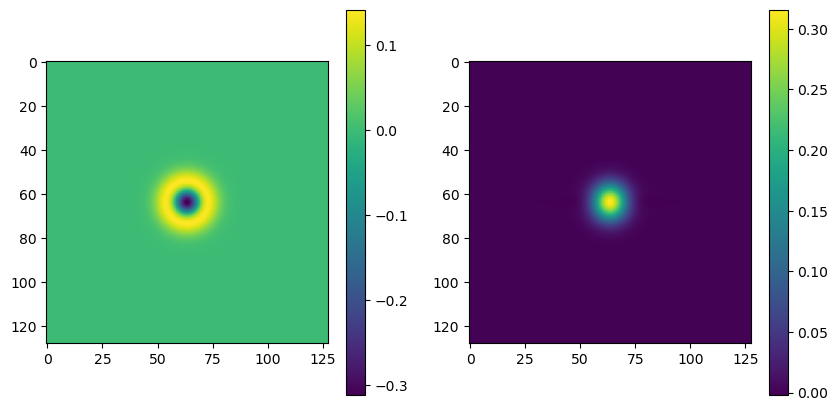

In [130]:
j = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
reddm1 = mp.find_reduced_density_matrix(list_for_matrices[j], 0, n1)
reddm2 = mp.find_reduced_density_matrix(list_for_matrices[j], 1, n2) 
reddm1 = reddm1 / np.trace(reddm1)
reddm2 = reddm2 / np.trace(reddm2)
x = np.linspace(-x_bond1, x_bond1, 2**n1) 
p = np.linspace(-x_bond1, x_bond1, 2**n1)
im1 = axes[0].imshow(mp.wigner_function3(reddm1, x, p, 1), cmap='viridis')
im2 = axes[1].imshow(mp.wigner_function3(reddm2, x, p, 1), cmap='viridis')
print("Количество фотонов в сигнале: ", np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic"), 3), "Количество фотонов в потерях: ", np.round(mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))
print("Общее количество фотонов: ", np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic") + mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

In [118]:
from operator import add
photon_number_in_mode1 = []
photon_number_in_mode2 = []
photon_number_common = []
for i in tqdm(range(0, len(list_for_matrices), 1)):
    reddm1 = mp.find_reduced_density_matrix(list_for_matrices[i], 0, n1)
    reddm2 = mp.find_reduced_density_matrix(list_for_matrices[i], 1, n2) 
    reddm1 = reddm1 / np.trace(reddm1)
    reddm2 = reddm2 / np.trace(reddm2)
    photon_number_in_mode1.append(np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic"), 3))
    photon_number_in_mode2.append(np.round(mp.calculate_ph_num(reddm2, n1, - x_bond1, step1, bound = "periodic"), 3))

 25%|████████████████████▊                                                              | 3/12 [00:39<01:59, 13.30s/it]


KeyboardInterrupt: 

In [185]:
photons = mp.calculate_photon_number_in_set_of_solutions(list_for_matrices, n1, n2, x_bond1, x_bond2, step1, step2, x_bias, mp.calculate_photon_number3, bound = False, step = 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.76s/it]


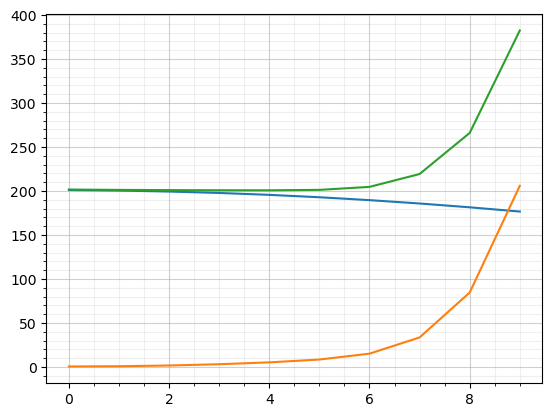

In [186]:
finish = 10 #len(photons[0])+1
plt.grid(which = 'major', alpha = 0.6)
plt.grid(which = 'minor', alpha = 0.2)
plt.minorticks_on()
plt.plot(photons[0][:finish])
plt.plot(photons[1][:finish])
plt.plot(np.array(photons[0][:finish]) + np.array(photons[1][:finish]))
plt.show()

In [27]:
def calculate_photon_number(set_of_solutions, n1, n2, x_bond1, x_bond2, step1, step2, step = 1):
    photon_number_in_mode1 = []
    photon_number_in_mode2 = []
    photon_number_common = []
    for i in tqdm(range(0, len(list_for_matrices), step)):
        reddm1 = mp.find_reduced_density_matrix(list_for_matrices[i], 0, n1)
        reddm2 = mp.find_reduced_density_matrix(list_for_matrices[i], 1, n2) 
        reddm1 = reddm1 / np.trace(reddm1)
        reddm2 = reddm2 / np.trace(reddm2)
        photon_number_in_mode1.append(np.round(mp.calculate_ph_num(reddm1, n1, - x_bond1, step1, bound = "periodic"), 3))
        photon_number_in_mode2.append(np.round(mp.calculate_ph_num(reddm2, n2, - x_bond2, step2, bound = "periodic"), 3))
        photon_number_common = list(map(add, photon_number_in_mode1, photon_number_in_mode2))
    return photon_number_in_mode1, photon_number_in_mode2, photon_number_common

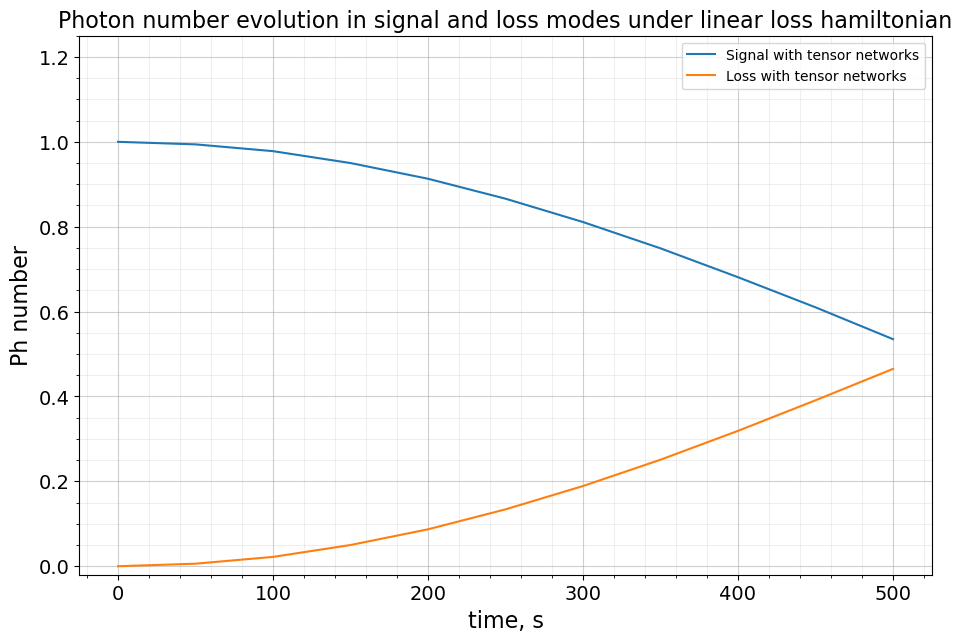

In [48]:
N = 11
plt.figure(figsize = (11,7))
plt.title('Photon number evolution in signal and loss modes under linear loss hamiltonian', fontsize = 16)
plt.plot(np.arange(N) * delta_t * 500, photon_number_in_mode1[:N], label = "Signal with tensor networks")
plt.plot(np.arange(N) * delta_t * 500, photon_number_in_mode2[:N], label = "Loss with tensor networks")
#plt.plot(np.arange(N) * delta_t * 500, list(map(add, photon_num1, photon_num2))[:N], label = "Sum")
#plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_signal, 'r+', label = "Signal with the matrix exponent")
#plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_loss, 'b+', label = "Loss with the matrix exponent")
plt.xlabel("time, s", fontsize = 16)
plt.ylabel("Ph number", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(which = 'major', alpha = 0.6)
plt.grid(which = 'minor', alpha = 0.2)
plt.ylim((-0.02, 1.25))
plt.minorticks_on()
plt.savefig("Photon number evolution in signal and loss modes under linear loss hamiltonian")

In [32]:
ggg = calculate_photon_number(list_for_matrices, n1, n2, x_bond1, x_bond2, step1, step2, step = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:02<00:00, 38.99it/s]


In [30]:
def plot_photon_number_evolution(photon_num1, photon_num2, time_step, delta_t, title, text1, text2, xlim = False, ylim = False, sum_ph_num = True):    
    plt.figure(figsize = (12,6))
    plt.title(title, fontsize = 16)
    plt.plot(np.arange(len(photon_num1)) * delta_t * time_step, photon_num1, label = text1)
    plt.plot(np.arange(len(photon_num2)) * delta_t * time_step, photon_num2, label = text2)
    if sum_ph_num:
        plt.plot(np.arange(len(photon_num2)) * delta_t * time_step, list(map(add, photon_num1, photon_num2)), label = "Sum")
    plt.xlabel("time, s", fontsize = 16)
    plt.ylabel("Photon number", fontsize = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.grid(which = 'major', alpha = 0.6)
    plt.grid(which = 'minor', alpha = 0.2)
    if xlim != False:
        plt.xlim(xlim)
    if ylim != False:
        plt.ylim(ylim)
    plt.minorticks_on()

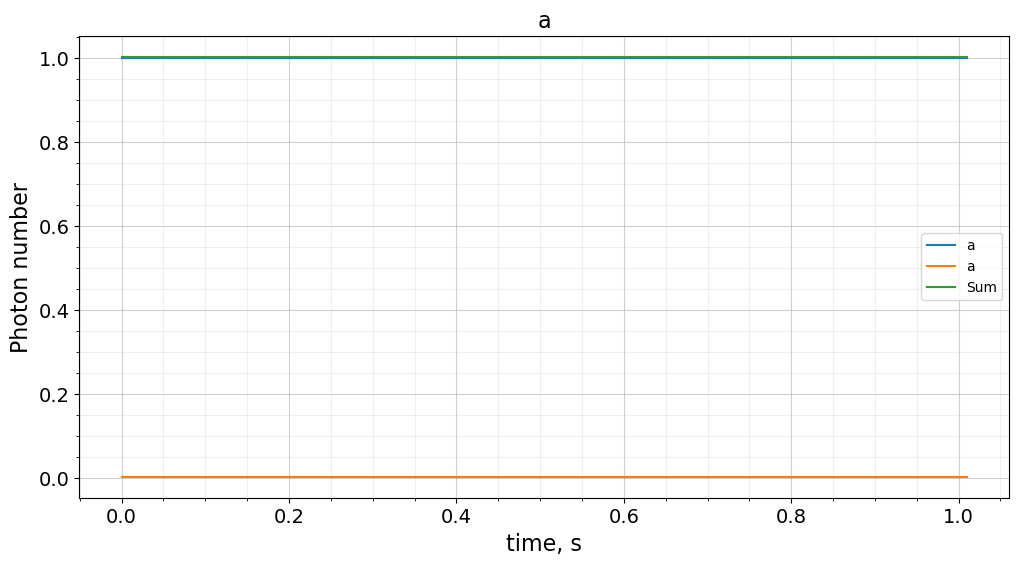

In [33]:
plot_photon_number_evolution(ggg[0], ggg[1], 1, delta_t, 'a', 'a', 'a')

In [28]:
(4,3) != False

True

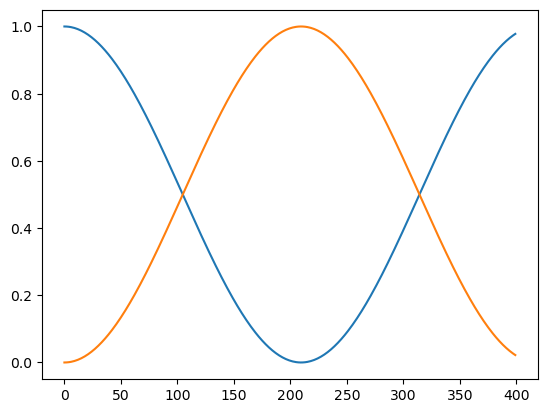

In [440]:
numm = np.arange(400)
plt.plot((np.cos(theta*delta_t*100*numm/2))**2)
plt.plot((np.sin(theta*delta_t*100*numm/2))**2)

In [378]:
len(photons_in_signal)

36

In [450]:
im4 = axes[1][1].plot((np.cos(theta*delta_t*100*numm/2))**2)

In [452]:
im4[0]

In [461]:
num = 10
gr4 = (np.cos(theta*delta_t*100*np.arange(num)/2))**2

In [462]:
gr4

array([1.        , 0.99994375, 0.99977502, 0.99949384, 0.99910027,
       0.99859441, 0.99797637, 0.99724628, 0.99640432, 0.99545067])

#### Создание гифки эволюции состояний под действием гамильтониана потерь

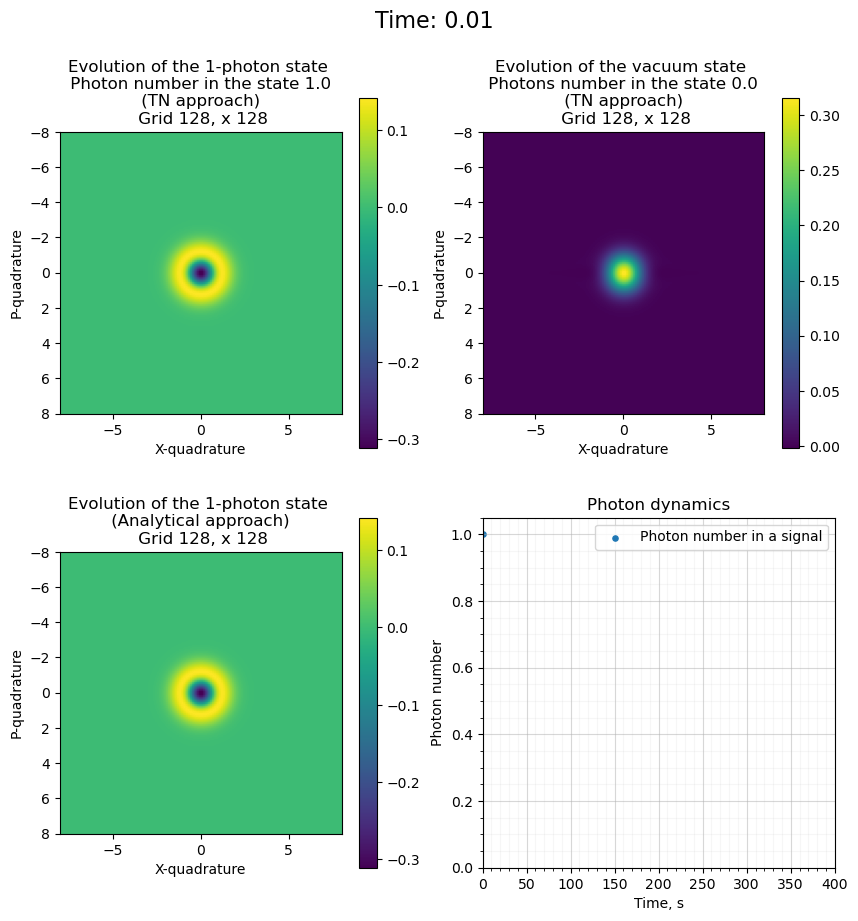

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = np.linspace(-x_bond1, x_bond1, 2**n1) 
p = np.linspace(-x_bond1, x_bond1, 2**n1)

extent1 = [-(2**n1)/2 * step1, (2**n1)/2 * step1, (2**n1)/2 * step1, -(2**n1)/2 * step1]
extent2 = [-(2**n2)/2 * step2, (2**n2)/2 * step2, (2**n2)/2 * step2, -(2**n2)/2 * step2]

first_matrix = mp.find_reduced_density_matrix(shorten_list_for_matrices[0], 0, n1)
second_matrix = mp.find_reduced_density_matrix(shorten_list_for_matrices[0], 1, n2)
first_matrix = first_matrix / np.trace(first_matrix)
second_matrix = second_matrix / np.trace(second_matrix)

im1 = axes[0][0].imshow(mp.wigner_function3(first_matrix, x, p, 1), cmap='viridis', extent = extent1)
#axes[0][0].set_title('Evolution of 1-photon state')
axes[0][0].set_xlabel('X-quadrature')
axes[0][0].set_ylabel('P-quadrature')
cbar1 = fig.colorbar(im1, ax=axes[0][0])
    
im2 = axes[0][1].imshow(mp.wigner_function3(second_matrix, x, p, 1), cmap='viridis', extent = extent2)
axes[0][1].set_xlabel('X-quadrature')
axes[0][1].set_ylabel('P-quadrature')
#axes[0][1].set_title('Evolution of a vacuum state')
cbar2 = fig.colorbar(im2, ax=axes[0][1])

im3 = axes[1][0].imshow(mp.wigner_function3(one_photon_dm_after_bs(1), x, p, 1), cmap='viridis', extent = extent1)
axes[1][0].set_xlabel('X-quadrature')
axes[1][0].set_ylabel('P-quadrature')
#axes[1][0].set_title('Evolution of 1-photon state')X
cbar3 = fig.colorbar(im3, ax=axes[1][0])

#h = np.zeros(len(shorten_list_for_matrices[:50]))
h = np.ones(1)
#h[0] = 1
    
im4 = axes[1][1].scatter(np.arange(len(h)), h, label = "Photon number in a signal", s=14)
axes[1][1].set_xlabel('Time, s')
axes[1][1].set_ylabel('Photon number')
#im4 = axes[1][1].plot((np.cos(theta*delta_t*100*numm/2))**2)
axes[1][1].set_title('Photon dynamics')
axes[1][1].set_xlim(0, 400)
axes[1][1].set_ylim(0, 1.05)
axes[1][1].grid(which = 'major',alpha = 0.5)
axes[1][1].grid(which = 'minor', alpha = 0.1)
axes[1][1].minorticks_on()
axes[1][1].legend()

cohn = mp.calculate_ph_num(first_matrix, n1, - x_bond1, step1)
vacn = mp.calculate_ph_num(second_matrix, n2, -x_bond2, step2)

text = fig.text(0.5, 0.95, f'Time: {0}', ha='center', fontsize=16)
#text1 = axes[0][0].text(0.5, 1.25, f'Number of photons in signal state {np.round(cohn, 1)}')
#text11 = axes[0][0].text(0.5, 1.15, f'Grid {2**n1}, x {2**n1}', ha='center')
#text2 = axes[0][1].text(0.5, 1.25, f'Number of photons in vacuum state {np.round(vacn, 1)}')
#text22 = axes[0][1].text(0.5, 1.15, f'Grid {2**n2}, x {2**n2}', ha='center')
#text3 = axes[0][0].text(1.3, 1.3, f'sum {np.round(np.round(np.round(cohn, 1), 1) + np.round(vacn, 1), 1)}, time {np.round(0, 2)}', ha='center')
axes[0][0].set_title(f'Evolution of the 1-photon state \n Photon number in the state {np.round(cohn, 2)} \n (TN approach) \n Grid {2**n1}, x {2**n1}')
axes[0][1].set_title(f'Evolution of the vacuum state \n Photons number in the state {np.round(vacn, 2)} \n (TN approach) \n Grid {2**n2}, x {2**n2}')
axes[1][0].set_title(f'Evolution of the 1-photon state \n (Analytical approach) \n Grid {2**n1}, x {2**n1}')
axes[1][1].set_title('Photon dynamics')

f = IntProgress(min = 0, max = len(shorten_list_for_matrices))
percentage = HTML(value='0%')

count = 0

def update(num):
    global n1, n2, count, x, p, h
    global x_bond1, x_bond2, x_bias, step1, step2, ph_num1, ph_num2, ph_num3, delta_t
    length = len(shorten_list_for_matrices)
    
    first_matrix = mp.find_reduced_density_matrix(shorten_list_for_matrices[num], 0, n1)
    second_matrix = mp.find_reduced_density_matrix(shorten_list_for_matrices[num], 1, n2)
    
    first_matrix = first_matrix / np.trace(first_matrix)
    second_matrix = second_matrix / np.trace(second_matrix)
    
    third_matrix = one_photon_dm_after_bs(np.cos(theta*delta_t*100*num/2))
    third_matrix = third_matrix / np.trace(third_matrix)
    
    cohn = mp.calculate_ph_num(first_matrix, n1,- x_bond1, step1)
    vacn = mp.calculate_ph_num(second_matrix, n2, -x_bond2, step2)
    
    wg1 = mp.wigner_function3(first_matrix, x, p, 1)
    wg2 = mp.wigner_function3(second_matrix, x, p, 1)
    wg3 = mp.wigner_function3(third_matrix, x, p, 1)
    
    #h = np.append(h, (np.cos(theta*delta_t*100*np.arange(num + 1)/2))**2)
    h = (np.cos(theta*delta_t*100*np.arange(num + 1)/2))**2
    gr4 = h
    
    im1.set_data(wg1)
    im2.set_data(wg2)
    im3.set_data(wg3)
    #im4.set_data(gr4)
    #im4.set_offsets(np.c_[np.arange(len(shorten_list_for_matrices[:50])), gr4])
    im4.set_offsets(np.c_[np.arange(len(gr4)), gr4])
    fig.canvas.draw_idle()  # Обновление отображения
    
    im1.set_clim(vmin=np.min(wg1), vmax=np.max(wg1))
    im2.set_clim(vmin=np.min(wg2), vmax=np.max(wg2))
    im3.set_clim(vmin=np.min(wg3), vmax=np.max(wg3))
    
#     axes[0][0].set_title(f'Number of photons in signal state {np.round(cohn, 1)}')
#     axes[0][0].set_title(f'Number of photons in vacuum state {np.round(vacn, 1)}')
#     text11.set_title(f'Grid {2**n1}, x {2**n1}')
#     text22.set_title(f'Grid {2**n2}, x {2**n2}')
    
    axes[0][0].set_title(f'Evolution of the 1-photon state \n Photon number in the state {np.round(cohn, 2)} \n (TN approach) \n Grid {2**n1}, x {2**n1}')
    axes[0][1].set_title(f'Evolution of the vacuum state \n Photons number in the state {np.round(vacn, 2)} \n (TN approach) \n Grid {2**n2}, x {2**n2}')
    axes[1][0].set_title(f'Evolution of the 1-photon state \n (Analytical approach) \n Grid {2**n1}, x {2**n1}')
    axes[1][1].set_title('Photon dynamics')
    #text3.set_title(f'sum {np.round(np.round(np.round(cohn, 1), 1) + np.round(vacn, 1), 1)}, time {np.round(delta_t * count, 2)}')
    
    text.set_text(f'Time: {np.round(count*delta_t, 2)}')
    #plt.text(0.5, 1, f'Time {np.round(delta_t * count, 4)}', transform=fig.transFigure, ha='center')
    #plt.text(0.5, 1.1, f'Number of photons in coherent state {np.round(cohn, 1)}, number of photons in vacuum state {np.round(vacn, 1)}', transform=fig.transFigure, ha='center')
    #plt.text(0.5, 1.05, f'sum {np.round(np.round(2 * np.round(cohn, 1), 1) + np.round(vacn, 1), 1)}', transform=fig.transFigure, ha='center')
    count += 1
    f.value += 1
    percentage.value = f'{int((f.value / length) * 100)}%'  # обновляем процент выполнения
    return im1, im2, im3, im4

ani = animation.FuncAnimation(fig, update, frames=len(shorten_list_for_matrices), interval=250, blit=True)

In [15]:
f = IntProgress(min = 0, max = len(shorten_list_for_matrices))
display(f)
percentage = HTML(value='0%')
display(percentage)

ani.save('animation_linear_loss_globalgif3.gif', writer='pillow', fps=4)

IntProgress(value=0, max=401)

HTML(value='0%')

In [478]:
gr4

array([1.        , 0.99994375, 0.99977502, 0.99949384, 0.99910027,
       0.99859441, 0.99797637, 0.99724628, 0.99640432, 0.99545067])

In [76]:
# Пример списка списков, содержащих массивы NumPy
list_of_lists_with_arrays = [[np.array([1, 2, 3]), np.array([4, 5, 6])], [np.array([7, 8, 9])]]

# Сохранение списка списков в файл с использованием pickle
with open('list_of_lists_with_arrays.pkl', 'wb') as f:
    pickle.dump(list_of_lists_with_arrays, f)

In [78]:
with open('list_of_lists_with_arrays.pkl', 'rb') as f:
    loaded_list_of_lists_with_arrays = pickle.load(f)

In [79]:
print(loaded_list_of_lists_with_arrays)

[[array([1, 2, 3]), array([4, 5, 6])], [array([7, 8, 9])]]


In [60]:
a = np.random.randn(16)
c = 1j*np.random.randn(16)
b = mp.vec_to_mps(a+c)

In [61]:
mp.mps_scalar_multiplication(b, b)

np.complex128(42.493433507820974+8.066266662622975e-32j)

In [64]:
np.conj((a+c)) @ (a+c)

np.complex128(42.49343350782095+0j)

In [137]:
def cycle(n):
    f = []
    for i in range(n):
        f.append(np.sqrt(i))
    print('Hello')

In [138]:
p = Process(target=cycle, args=(2**23,))
p.start()
p.join()

In [139]:
p

<Process name='Process-12' pid=21232 parent=2088 stopped exitcode=1>

In [140]:
cycle(2**23)

Hello


In [142]:
# SuperFastPython.com
# example of running a function in another process
from time import sleep
from multiprocessing import Process
 
# a custom function that blocks for a moment
def task():
    # block for a moment
    sleep(1)
    # display a message
    print('This is from another process', flush=True)
 
# entry point
if __name__ == '__main__':
    # create a process
    process = Process(target=task)
    # run the process
    process.start()
    # wait for the process to finish
    print('Waiting for the process...', flush=True)
    process.join()

Waiting for the process...


In [ ]:
from multiprocessing import Process, Queue

# Функция, которая возвращает числовые значения
def task(queue):
    # Пример вычисления
    result = 42
    # Передача результата в очередь
    queue.put(result)

# Точка входа
if __name__ == '__main__':
    # Создание очереди для передачи данных
    queue = Queue()

    # Создание процесса
    process = Process(target=task, args=(queue,))

    # Запуск процесса
    process.start()

    # Ожидание завершения процесса
    process.join()

    # Получение результата из очереди
    result = queue.get()
    print(f'Result from another process: {result}')


#### Тестирование того, как растет норма состояния (сигнал + потери) в ходе эволюции с разными шагами по времени

In [46]:
t_common = 1
max_num_steps = 40000
all_solutions = []
norm_lists = []
steps_pull = [max_num_steps, max_num_steps/2, max_num_steps/4, max_num_steps/5, max_num_steps/8, max_num_steps/10,
              max_num_steps/20, max_num_steps/40, max_num_steps/50, max_num_steps/80, max_num_steps/100, max_num_steps/200,
             max_num_steps/400, max_num_steps/500, max_num_steps/800, max_num_steps/1000, max_num_steps/2000, max_num_steps/4000]
steps_pull = [int(step) for step in steps_pull]

In [47]:
# with open('State norm test norms.pkl', 'wb') as f:
#     pickle.dump(norm_lists, f)

In [48]:
for steps in steps_pull:
    ev_matrix = mp.mpo_sum(mp.one_mpo(n1 + n2), mp.mpo_mul_num(hamiltonian, 1j*t_common/steps))
    all_solutions.append(evolute(common_mps, ev_matrix, steps, mp.mp_solve))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.62it/s]


In [49]:
for solution_ in all_solutions:
    norms = []
    step_in = int(len(solution_)/10)
    for i in tqdm(range(0, len(solution_), step_in)):
        norms.append(np.linalg.norm(mp.tensors_multiplication(solution_[i]))/np.linalg.norm(mp.tensors_multiplication(solution_[0])))
    norm_lists.append(norms)

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 100.39it/s]


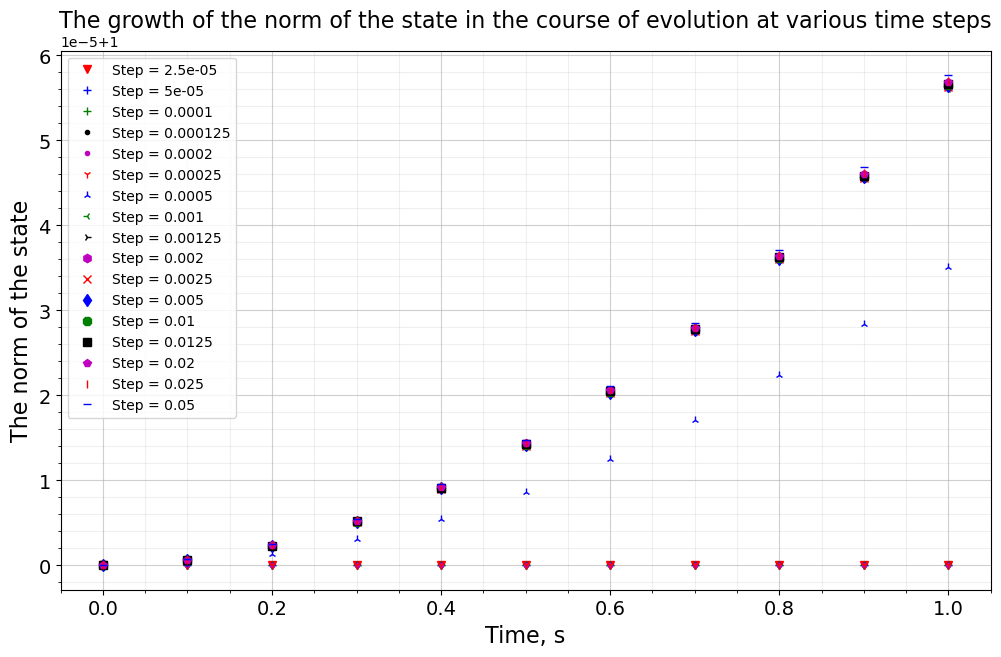

In [50]:
plt.figure(figsize = (12,7))
line_types = ['rv', 'b+', 'g+', 'k.', 'm.', 'r1', 'b2', 'g3', 'k4', 'mh', 'rx', 'bd', 'g8', 'ks', 'mp', 'r|', 'b_']
count = 0
for norm in norm_lists[:17]:
    plt.plot(np.linspace(0, t_common, len(norm)), norm, line_types[count], label = f"Step = {t_common/steps_pull[count]}")
    count += 1

plt.title("The growth of the norm of the state in the course of evolution at various time steps", fontsize = 16)
plt.xlabel("Time, s", fontsize = 16)
plt.ylabel("The norm of the state", fontsize = 16)
plt.legend()
plt.grid(which = 'major', alpha = 0.6)
plt.grid(which = 'minor', alpha = 0.2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 1)
plt.minorticks_on()
#plt.savefig("The growth of the norm of the state in the course of evolution at various time steps 2.png", bbox_inches="tight")

In [121]:
norm_lists = []

In [188]:
delta_t

0.00025

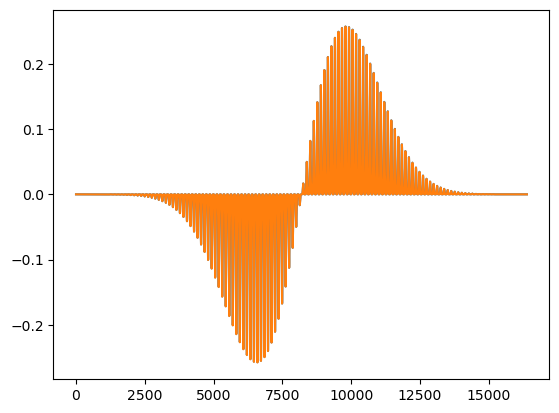

In [197]:
plt.plot(mp.tensors_multiplication(list_for_matrices[0]))
plt.plot(mp.tensors_multiplication(list_for_matrices[140000]))

In [9]:
fmatrix = ev_matrix

In [10]:
aaa = mp.mpo_to_matrix(fmatrix)

In [15]:
bbb = mp.mpo_to_matrix(ev_matrix)

In [20]:
np.linalg.norm(aaa - bbb)/np.linalg.norm(aaa)

np.float64(6.901508050546836e-05)

In [21]:
np.linalg.cond(aaa)

np.float64(1.0004332859743816)

In [22]:
np.linalg.cond(bbb)

np.float64(1.0008667597261791)

In [2]:
!pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [3]:
!pip show scipy

Name: scipy
Version: 1.15.1
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2024, SciPy Developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions
 are met:

 1. Redistributions of source code must retain the above copyright
    notice, this list of conditions and the following disclaimer.

 2. Redistributions in binary form must reproduce the above
    copyright notice, this list of conditions and the following
    disclaimer in the documentation and/or other materials provided
    with the distribution.

 3. Neither the name of the copyright holder nor the names of its
    contributors may be used to endorse or promote products derived
    from this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLD

### Вычисление эволюции с помощью матричной экспоненты

#### Запись операторов рождения и уничтожения числа фотонов в фотонном базисе (конечномерном, длины 10)

In [30]:
import scipy
import operator

$\hat{a} = 
\
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \sqrt{3} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \sqrt{4} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \sqrt{5} & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sqrt{6} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{7} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{8} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{9}\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{pmatrix}
$

$\hat{a}^{\dagger} = 
\
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \sqrt{3} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{4} & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \sqrt{5} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \sqrt{6} & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sqrt{7} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{8} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sqrt{9} & 0\\
\end{pmatrix}
$

In [31]:
def annihilate_photon(n):
    A = np.zeros((n, n))
    for i in range(len(A)-1):
        A[i][i+1] = np.sqrt(i+1)
    return A
annihilate_photon(3)

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.41421356],
       [0.        , 0.        , 0.        ]])

In [32]:
def create_photon(n):
    A = np.zeros((n, n))
    for i in range(1, len(A)):
        A[i][i-1] = np.sqrt(i)
    return A
create_photon(3)

array([[0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.41421356, 0.        ]])

In [33]:
def tensor_product(a, b):
    if len(a.shape) == 2:
        return np.einsum("ijk, klm -> iljm", a.reshape(a.shape[0], a.shape[1], 1), b.reshape(1, b.shape[0], b.shape[1])).reshape(a.shape[0]*b.shape[0], a.shape[1]*b.shape[1])
    else:
        return np.einsum("ik, km -> im", a.reshape(a.shape[0], 1), b.reshape(1, b.shape[0])).reshape(a.shape[0]*b.shape[0])

#### Гамильтониан светоделителя (потерь)

$\hat{H}_{bs} = \dfrac{\theta}{2i}(\hat{a}^{\dagger}_{sig}\hat{a}_{loss} - \hat{a}_{sig}\hat{a}^{\dagger}_{loss})$

#### Параметры

In [219]:
theta_ = 0.015
t = 70
n = 12

#### Запись гамильтониана

In [220]:
ham_bs = - (theta_ * 1j / 2) * (tensor_product(create_photon(n), annihilate_photon(n)) - tensor_product(annihilate_photon(n), create_photon(n)))
ham_bs

array([[0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       ...,
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]])

#### Начальная волновая функция $\psi_0$

In [221]:
def create_fock_state(photon_numbers, n):
    a = np.zeros(n)
    a[photon_numbers] = 1 
    return a
create_fock_state(2,4)

array([0., 0., 1., 0.])

#### Функция, решающая уравнение через матричную экспоненту

In [222]:
def solve_with_matrexp(hamiltonian, time, psi0):
    return scipy.linalg.expm(-1j * hamiltonian * time) @ psi0

In [223]:
#scipy.linalg.expm(-1j * ham_bs * 70)

In [224]:
matr_exp_solution = solve_with_matrexp(ham_bs, t, tensor_product(create_fock_state(1, n), create_fock_state(0, n)))
#matr_exp_solution

#### Разложение тензорного произведения двух волновых функций на произведение

In [19]:
def decompose_tp(tensor_product):
    n = int(np.sqrt(len(tensor_product)))
    matrix = tensor_product.reshape(n, n)
    U, S, V = np.linalg.svd(matrix, full_matrices = True)
    return [S[0], S[1]]

In [20]:
#np.linalg.svd(matr_exp_solution.reshape(n, n), full_matrices = True)

In [21]:
delta_time = 5
photons_in_signal = []
photons_in_loss = []
for t_ in tqdm(range(0, 36)):
    result = decompose_tp(solve_with_matrexp(ham_bs, t_ * delta_time, tensor_product(create_fock_state(1, n), create_fock_state(0, n))))
    photons_in_signal.append(result[0]**2)
    photons_in_loss.append(result[1]**2)

  0%|                                                                                           | 0/36 [00:00<?, ?it/s]


NameError: name 'solve_with_matrexp' is not defined

(np.float64(0.9347535907329925), np.float64(0.06524640926700777))

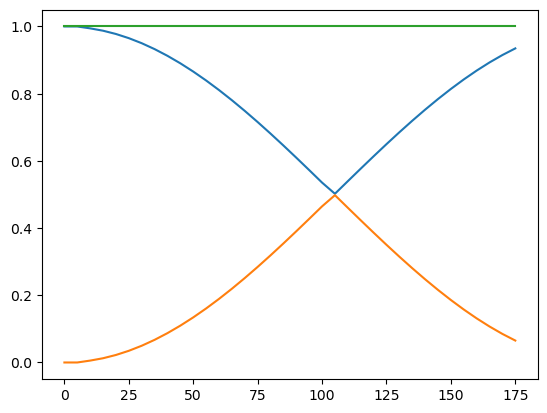

In [365]:
plt.plot(range(0, 36*delta_time, delta_time), photons_in_signal)
plt.plot(range(0, 36*delta_time, delta_time), photons_in_loss)
plt.plot(range(0, 36*delta_time, delta_time), list(map(operator.add, photons_in_signal, photons_in_loss)))
photons_in_signal[-1], photons_in_loss[-1]

In [52]:
#mp.mpo_to_matrix(mp.mpo_sum(mp.der_mpo(n2, step2), ))

In [12]:
def bound_part(n, c1, c2):
    mpo = mp.mpo_sum([np.array([[0,1],[0,0]]).reshape(1,2,2,1)]*(n-1) + [np.array([[0,-c1],[0,0]]).reshape(1,2,2,1)], [np.array([[0,0],[1,0]]).reshape(1,2,2,1)]*(n-1) + [np.array([[0,0],[c2,0]]).reshape(1,2,2,1)]) 
    return mpo

In [37]:
mp.mpo_to_matrix(bound_part(3, 0.1, 0.3))

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [2]:
mp.calculate_ph_num()

TypeError: calculate_ph_num() missing 4 required positional arguments: 'rho', 'n', 'x0', and 'step'

#### Динамика числа фотонов через формулы из лекций Саши Львовского

In [143]:
scipy.special.binom(1,0)

np.float64(1.0)

In [141]:
scipy.special.binom(5,3)

np.float64(10.0)

In [237]:
np.pi/3 / 0.015

69.81317007977317

In [150]:
210*0.015/2

1.575

In [267]:
np.sqrt(1 - 0.25)

np.float64(0.8660254037844386)

In [337]:
omega = 0.015
t1 = np.arange(200)

reflection = np.sin(omega*t1/2)
transition = np.cos(omega*t1/2)

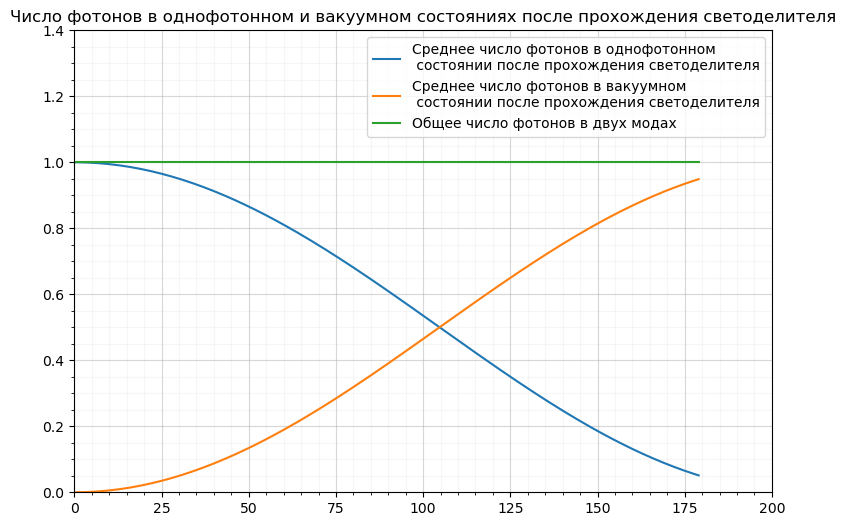

In [399]:
plt.figure(figsize = (9,6))
plt.title("Число фотонов в однофотонном и вакуумном состояниях после прохождения светоделителя")
plt.plot(transition**2, label = 'Среднее число фотонов в однофотонном \n состоянии после прохождения светоделителя')
plt.plot(reflection**2, label = 'Среднее число фотонов в вакуумном \n состоянии после прохождения светоделителя')
plt.plot(transition**2 + reflection**2, label = 'Общее число фотонов в двух модах')
plt.ylim(0,1.4)
plt.xlim(0,200)
plt.grid(which = 'major',alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.minorticks_on()
plt.legend()

## Прохождение однофотонного фоковского квантового состояния через светделитель с амплитудным показателем пропускания "transmission"

### Вычисление изменения матрицы плотности (лекции А.Львовского)

#### Оператор плотности квантового состояния в фоковском базисе имеет вид:

 $ \widehat   \rho  =  \sum   \rho _ {mn}  |m\rangle \langle n| \tag{1} $


#### Можно показать (см. лекции), что после прохождения светоделителя оператор плотности общего состояния (квантового состояния $(*)$ и вакуумного состояиня) будет иметь вид:

 $ \widehat{P}=  \sum _ {m,n}  \sum _ {i=0}^ {m} \sum _ {k=0}^ {n}  \rho _ {mn} A_ {mj} A_ {nk} |m-j,j \rangle  \langle n-k,k| (**) \tag{2} $

$A_{n k}=\sqrt{\binom{n}{k}} t^{n-k} r^k$

#### Взяв след по оператору плотности второго состояния (вакуумного), получаем оператор плотности квантового состояния после прохождения светоделителя:

$ \widehat \rho _ {out} = Tr_ {2} \widehat {P} =  \sum _ {m,n}  
  \sum _ {k=0}^ {min(m,n)}  \rho _ {mn} A_ {mk} A_ {nk}  |m-k \rangle \langle n-k| \tag{3} $

#### В случае, когда квантовое состояние на входе в светоделитель - однофотонное фоковское состояние - оператор плотности $(***)$ принимает совсем простой вид:

$ \widehat \rho _ {out} = A_ {10} A_ {10}  |1 \rangle \langle 1| + A_ {11} A_ {11}  |0 \rangle \langle 0| = t^2  |1 \rangle \langle 1| + r^2  |0 \rangle \langle 0| \tag{4} $

#### Матрица плотности этого состояния в координатном базисе принимает следующий вид:

$\rho (x, x^{'}) = \langle x|\widehat \rho _ {out} |x^{'} \rangle = t^2  \langle x||1 \rangle \langle 1||x^{'} \rangle + r^2  \langle x||0 \rangle \langle 0||x^{'} \rangle = t^2 \psi_1(x) \psi_1^{*}(x^{'}) + r^2 \psi_0(x) \psi_0^{*}(x^{'}) \tag{5} $

#### Запись выше означает, что выходное состояние светоделителя является суперпозицией вакуумного и однофотонного фоковского состояний. Также видно, что с вероятностью t^2 мы обнаруживаем однофотонное квантовое состояние, а с вероятностью r^2 - вакуумное состояние, таким образом, среднее число фотонов на выходе равно:

$\langle n \rangle = t^2 = \cos^2(\Omega T/2) \tag{6} $

#### $\Omega$ появляется, если мы рассматриваем прохождение светоделителя как эволюцию моды сигнала и моды с вакуумом в течение времени T под действием гамильтониана $\hat{H}_{\mathrm{BS}}=\dfrac{\Omega i}{2}\left(\hat{a}_1 \hat{a}_2^{\dagger}-\hat{a}_1^{\dagger} \hat{a}_2\right)$. Такая эволюция соответсвует амплитудному коэффициенту пропускания светоделителя t, что видно из уравнения (6).

#### Формула (5) позволяет построить матрицу плотности однофотонного квантового фоковского состояния после прохождения светоделителя при любом коэффициенте пропускания t (transmission):

In [17]:
def one_photon_dm_after_bs(transmission):
    return transmission**2 * np.outer(psi_fock(1, np.linspace(-x_bond1, x_bond1, 2**n1)), np.conj(psi_fock(1, np.linspace(-x_bond1, x_bond1, 2**n1)))) + (1-transmission**2) * np.outer(psi_fock(0, np.linspace(-x_bond1, x_bond1, 2**n1)), np.conj(psi_fock(0, np.linspace(-x_bond1, x_bond1, 2**n1))))

#### Например, если пропускание светоделителя нулевое (t = 0), то на выходе получаем вакуумное состояние, что ожидаемо:

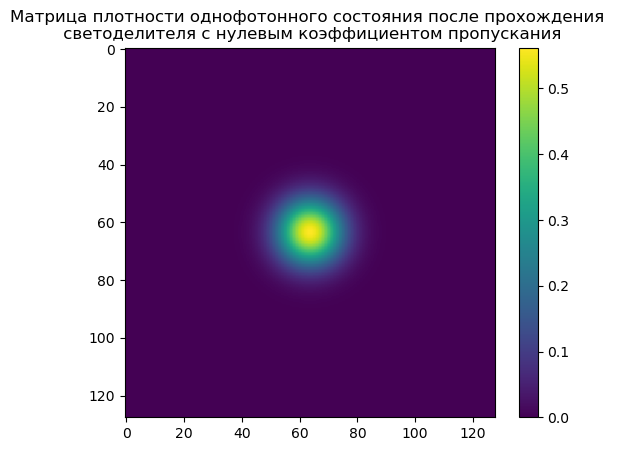

In [332]:
plt.title("Матрица плотности однофотонного состояния после прохождения \n светоделителя с нулевым коэффициентом пропускания")
plt.imshow(one_photon_dm_after_bs(0))
plt.colorbar()

#### Используя формулу (6), можно также показать, как будет меняться среднее число фотонов в модах на выходе светоделителя при разных коэффициентах пропускания (t):

In [360]:
omega = 0.015
t1 = np.arange(180)
reflection = np.sin(omega*t1/2)
transition = np.cos(omega*t1/2)

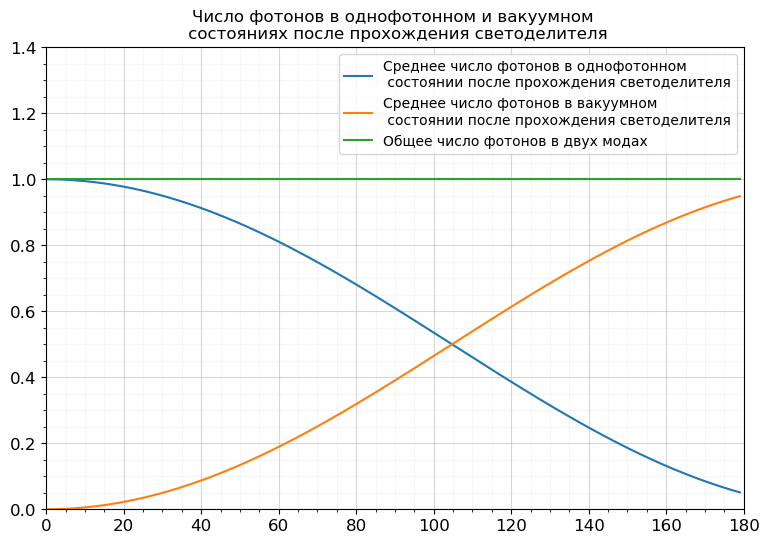

In [403]:
plt.figure(figsize = (9,6))
plt.title("Число фотонов в однофотонном и вакуумном \n состояниях после прохождения светоделителя")
plt.plot(transition**2, label = 'Среднее число фотонов в однофотонном \n состоянии после прохождения светоделителя')
plt.plot(reflection**2, label = 'Среднее число фотонов в вакуумном \n состоянии после прохождения светоделителя')
plt.plot(transition**2 + reflection**2, label = 'Общее число фотонов в двух модах')
plt.ylim(0,1.4)
plt.xlim(0,180)
plt.grid(which = 'major',alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.minorticks_on()
plt.legend()

### Для сравнения вычислим эволюцию числа фотонов в модах с помощью матричной экспоненты и наложим на график выше

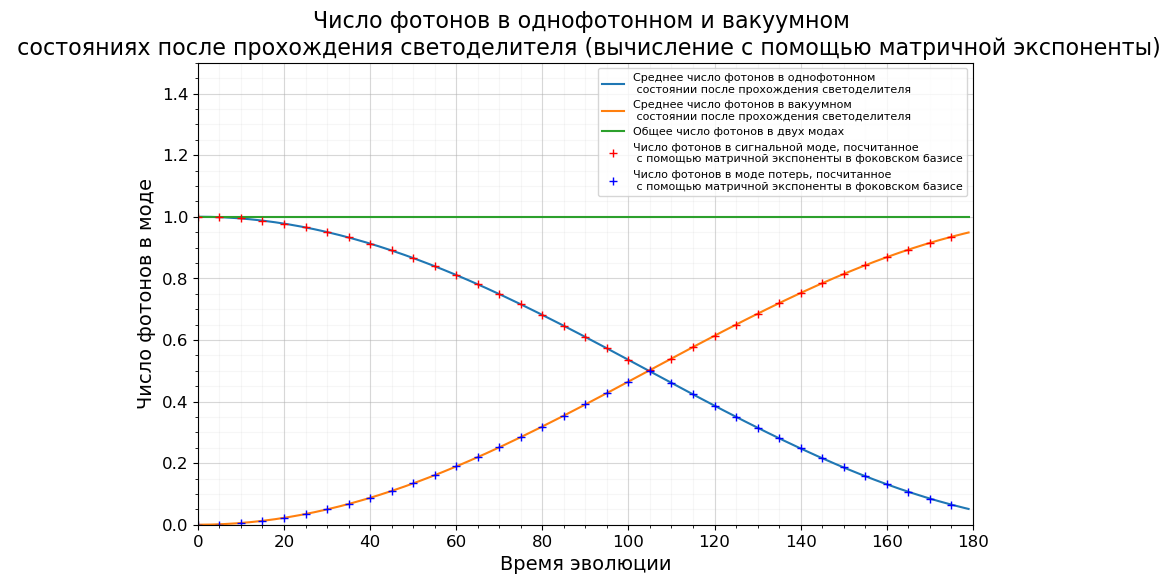

In [503]:
plt.figure(figsize = (10,6))
plt.title("Число фотонов в однофотонном и вакуумном \n состояниях после прохождения светоделителя (вычисление с помощью матричной экспоненты)", fontsize = 16)
plt.plot(transition**2, label = 'Среднее число фотонов в однофотонном \n состоянии после прохождения светоделителя')
plt.plot(reflection**2, label = 'Среднее число фотонов в вакуумном \n состоянии после прохождения светоделителя')
plt.plot(transition**2 + reflection**2, label = 'Общее число фотонов в двух модах')
plt.xlabel('Время эволюции', fontsize = 14)
plt.ylabel('Число фотонов в моде', fontsize = 14)
plt.ylim(0,1.5)
plt.xlim(0,180)
plt.grid(which = 'major',alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.minorticks_on()

plt.plot(range(0, 36*delta_time, delta_time), photons_in_signal, 'r+', label = 'Число фотонов в сигнальной моде, посчитанное \n с помощью матричной экспоненты в фоковском базисе')
plt.plot(range(0, 36*delta_time, delta_time), photons_in_loss, 'b+', label = 'Число фотонов в моде потерь, посчитанное \n с помощью матричной экспоненты в фоковском базисе')
#plt.plot(range(0, 36*delta_time, delta_time), list(map(operator.add, photons_in_signal, photons_in_loss)), 'g+')
photons_in_signal[-1], photons_in_loss[-1]

plt.legend(fontsize= 8)

### Сделаем аналогичное вычисление с помощью тензорных сетей

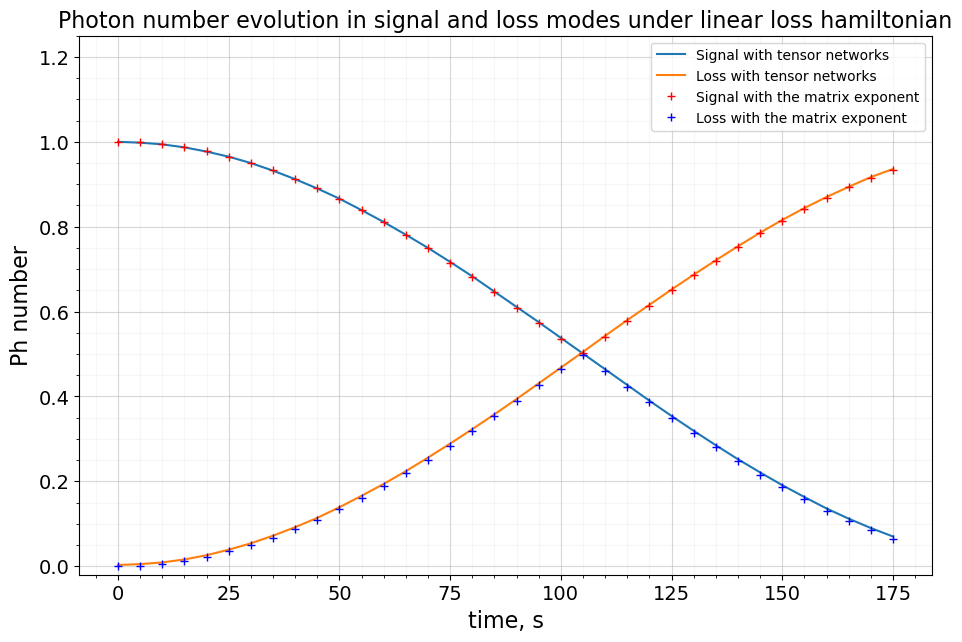

In [404]:
N = 36
plt.figure(figsize = (11,7))
plt.title('Photon number evolution in signal and loss modes under linear loss hamiltonian', fontsize = 16)
plt.plot(np.arange(N) * delta_t * 500, photon_num1[:N], label = "Signal with tensor networks")
plt.plot(np.arange(N) * delta_t * 500, photon_num2[:N], label = "Loss with tensor networks")
#plt.plot(np.arange(N) * delta_t * 500, list(map(add, photon_num1, photon_num2))[:N], label = "Sum")
plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_signal, 'r+', label = "Signal with the matrix exponent")
plt.plot(np.linspace(0, 175, len(photons_in_signal)), photons_in_loss, 'b+', label = "Loss with the matrix exponent")
plt.xlabel("time, s", fontsize = 16)
plt.ylabel("Ph number", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.1)
plt.ylim((-0.02, 1.25))
plt.minorticks_on()
plt.savefig("Photon number evolution in signal and loss modes under linear loss hamiltonian")

#### Все три подхода - аналитическая зависимость, решение с помощью матричной экспоненты и решение с помощью тензорных сетей дают полностью эквивалентный результат

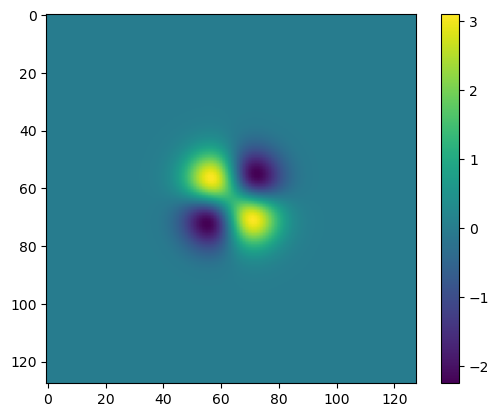

In [270]:
plt.imshow(np.real(dmatrix1))
plt.colorbar()

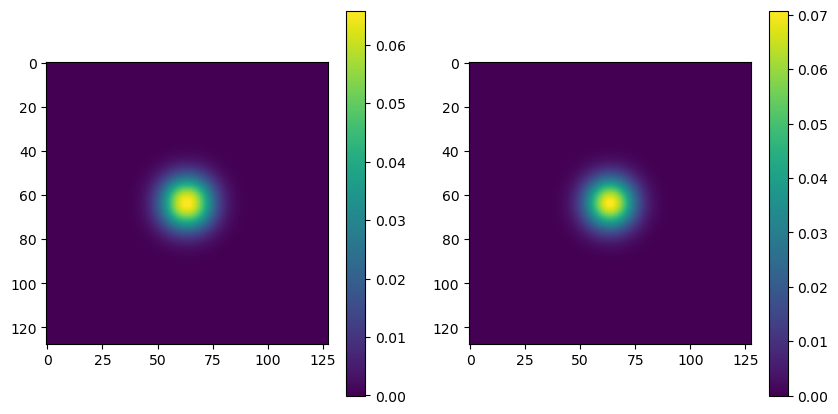

In [424]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dmatrix_loss0 = mp.find_reduced_density_matrix(list_for_matrices[0], 1, n2)
dmatrix_loss00 = one_photon_dm_after_bs(0)
im1 = axes[0].imshow(np.real(dmatrix_loss0/np.trace(dmatrix_loss0)))
im2 = axes[1].imshow(np.real(dmatrix_loss00/np.trace(dmatrix_loss00)))
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

321 μs ± 9.58 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


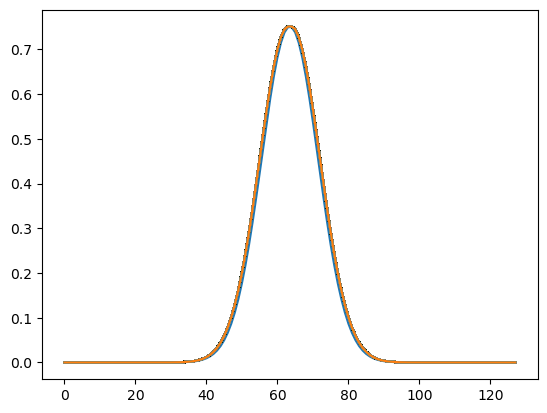

In [16]:
vac_state_0 = psi_fock(0, np.linspace(-x_bond1, x_bond1, 2**n1))
vac_state_1 = mp.tensors_multiplication(mp.vacuum_state(x_bond2, n2))
plt.plot(vac_state_0)
plt.plot(vac_state_1)

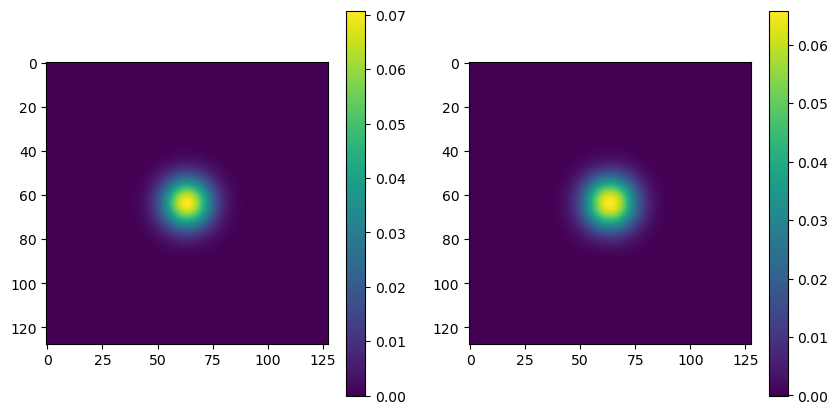

In [305]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dmatrix_loss0 = np.outer(vac_state_0, np.conj(vac_state_0))
dmatrix_loss00 = np.outer(vac_state_1, np.conj(vac_state_1))
im1 = axes[0].imshow(np.real(dmatrix_loss0/np.trace(dmatrix_loss0)))
im2 = axes[1].imshow(np.real(dmatrix_loss00/np.trace(dmatrix_loss00)))
fig.colorbar(im1, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

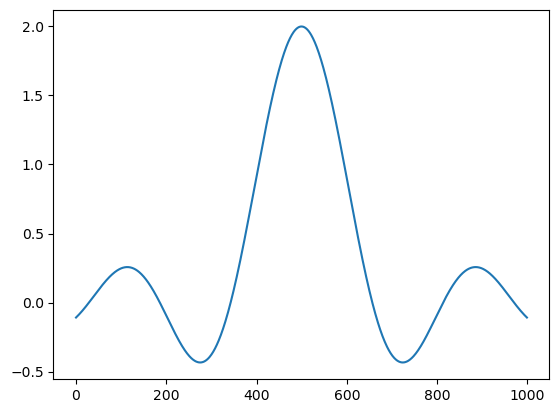

In [19]:
x = np.linspace(-10, 10, 1000)
plt.plot((np.sin(x)/x)*2)

In [84]:
def calculate_photon_number3(mps, position, length):
    l = len(mps)
    state_part = mps[position*(l - length):length*(1-position)+l*position]
    env_part = mps[(1-position)*length:(l-length)*position+l*(1-position)]
    return state_part, env_part

In [85]:
test_list = [0,1,2,3,4,5,6,7,8,9]

In [93]:
calculate_photon_number3(test_list, 1, 9)

([1, 2, 3, 4, 5, 6, 7, 8, 9], [0])

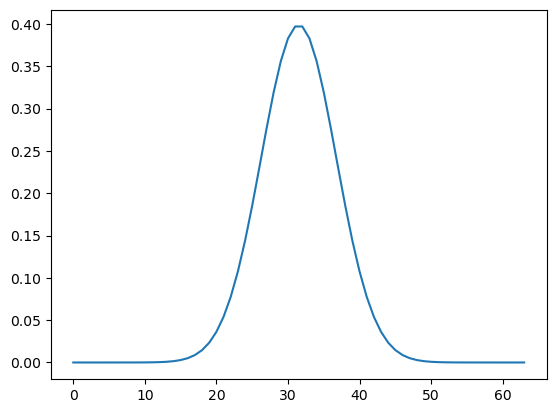

In [9]:
plt.plot(mp.tensors_multiplication(mp.asym_gauss_mps(6, 6, 6, 1)))

In [23]:
for i in mp.sym_gauss_mps(6, 1, 9):
    print(i.shape)

(1, 2, 2)
(2, 2, 4)
(4, 2, 6)
(6, 2, 10)
(10, 2, 8)
(8, 2, 8)
(8, 2, 6)
(6, 2, 4)
(4, 2, 1)
